In [1]:
import requests
from io import StringIO
import pandas as pd
import numpy as np
import sqlite3
sqlite3.register_adapter(np.int64, int)
import re
import math
from datetime import date
import matplotlib.pyplot as plt

# 展開所有dataframe columns
pd.set_option('display.max_rows', 2000)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.set_option ('display.max_colwidth',500)

# 不縮寫成科學記號
pd.set_option('display.float_format',lambda x : '%.2f' % x)

db = sqlite3.connect('./stock.db' , isolation_level=None)

In [2]:
# 下次換季時間： 11/14, 3/31, 5/15, 8/14 
QUARTERS = ['2022q3','2022q4','2023q1','2023q2']
CURRENT_QUARTER = QUARTERS[-1][-2:]
CURRENT_QUARTERS = list(map(lambda q: q[-2:], QUARTERS))
CURRENT_YEAR = int(QUARTERS[-1][0:4])
LAST_YEAR_QUARTER = '2022q4'
CURRENT_YEARS = [2018, 2019, 2020, 2021, 2022]
print("QUARTERS:", QUARTERS)
print("CURRENT_QUARTER:", CURRENT_QUARTER)
print("CURRENT_QUARTERS:", CURRENT_QUARTERS)
print("CURRENT_YEAR:", CURRENT_YEAR)
print("LAST_YEAR_QUARTER:", LAST_YEAR_QUARTER)
print("CURRENT_YEARS:", CURRENT_YEARS)

QUARTERS: ['2022q3', '2022q4', '2023q1', '2023q2']
CURRENT_QUARTER: q2
CURRENT_QUARTERS: ['q3', 'q4', 'q1', 'q2']
CURRENT_YEAR: 2023
LAST_YEAR_QUARTER: 2022q4
CURRENT_YEARS: [2018, 2019, 2020, 2021, 2022]


In [3]:
# 查詢股本table
df_stock_id_name = pd.read_sql_query("select * from stockIdName",db)
print(len(df_stock_id_name))
df_stock_id_name.head()

1780


,id,name,listingDate,market,industry,capital
0,1101,台泥,1962/02/09,上市,水泥工業,69.37
1,1102,亞泥,1962/06/08,上市,水泥工業,35.46
2,1103,嘉泥,1969/11/14,上市,水泥工業,7.75
3,1104,環泥,1971/02/01,上市,水泥工業,6.54
4,1108,幸福,1990/06/06,上市,水泥工業,4.05


In [4]:
out = df_stock_id_name[['id', 'name', 'market', 'industry', 'capital']]
out.head()

,id,name,market,industry,capital
0,1101,台泥,上市,水泥工業,69.37
1,1102,亞泥,上市,水泥工業,35.46
2,1103,嘉泥,上市,水泥工業,7.75
3,1104,環泥,上市,水泥工業,6.54
4,1108,幸福,上市,水泥工業,4.05


In [5]:
ids = out['id'].tolist()

# 用的到的table(加速運算時間,不用每個id都查db)

In [6]:
# 月營收
monthly = pd.read_sql_query(f"select * from monthlyRevenue order by date" , db)
# 日收盤
daily = pd.read_sql_query("select * from daily",db)
daily = daily.sort_values(by=['date'])
# 現金流量表
cashflow = pd.read_sql_query("select * from cashflow order by date",db)
# 財報
df_financial_statement = pd.read_sql_query("select * from financialStatement order by date",db)
df_financial_statement = df_financial_statement.fillna(0)
df_financial_statement.replace('--', 0, inplace=True)
# 負債表
df_debt = pd.read_sql_query(f"select * from balanceSheet order by date",db)

# YoY > 0筆數

月營收yoy>0筆數

In [7]:
def countYoYGreaterThan0(id):
    df = monthly[(monthly['id']==id) & (monthly['YoY'] > 0)]
    
    try:
        return len(df)
    except:
        return np.nan
    
count = [countYoYGreaterThan0(id) for id in ids]
out['yoyIncreaseCount'] = count

In [8]:
out.sort_values(by=['yoyIncreaseCount'], ascending=False).head(10)

,id,name,market,industry,capital,yoyIncreaseCount
521,3023,信邦,上市,電子零組件業,2.36,69
1179,3587,閎康,上櫃,其他電子業,0.62,69
914,8454,富邦媒,上市,貿易百貨業,2.18,68
1081,3218,大學光,上櫃,生技醫療業,0.80,68
1570,6469,大樹,上櫃,生技醫療業,0.89,68
841,6592,和潤企業,上市,其他業,5.15,67
960,9941,裕融,上市,其他業,5.47,67
1600,6561,是方,上櫃,通信網路業,0.71,67
623,3653,健策,上市,電子零組件業,1.34,66
1717,8284,三竹,上櫃,資訊服務業,0.46,66


# 月營收

In [9]:
# 近12月營收平均
def TTMRevenueCal(id):
    df = monthly[(monthly['id']==id)].tail(12)

    try:
        TTMRevenue = round((df['revenue'].sum()/100000),2)
        TTMYoY = round(df['sumYoY'].mean() ,2)
        return TTMRevenue, TTMYoY
    except:
        return np.nan

out['TTMRevenue'] = [TTMRevenueCal(id)[0] for id in ids]
out['TTMYoY'] = [TTMRevenueCal(id)[1] for id in ids]

# TTMRevenueCal(2330)

In [10]:
out[out['id'].isin([2330,3037])]

,id,name,market,industry,capital,yoyIncreaseCount,TTMRevenue,TTMYoY
274,2330,台積電,上市,半導體業,259.30,53,21617.39,11.94
535,3037,欣興,上市,電子零組件業,14.75,56,1150.36,-3.91


# 毛利率(Gross Profit Margin)
# 營業利益率(Operating profit Margin)
# 淨利率(Net profit margin)

In [11]:
df_financial_statement['grossProfitMargin'] = df_financial_statement['grossProfit'].div(df_financial_statement['revenue'])
df_financial_statement['operatingProfitMargin'] = df_financial_statement['operatingIncome'].div(df_financial_statement['revenue'])
df_financial_statement['netProfitMargin'] = df_financial_statement['income'].div(df_financial_statement['revenue'])

In [12]:
# 近四季毛利率、營業利益率、淨利率
def writeToOut(id, date, col):
    df = df_financial_statement[(df_financial_statement['date']==date) & (df_financial_statement['id']==id)]
    try: 
        return round(df[col].iloc[0], 2)
    except:
        return np.nan

cols = ['grossProfitMargin', 'operatingProfitMargin', 'netProfitMargin']

for col in cols:
    for idx, quarter in enumerate(QUARTERS):
        out[f'{col}{CURRENT_QUARTERS[idx]}'] = [writeToOut(id, quarter, col) for id in ids]

# writeToOut(2330, '2023q2', 'grossProfitMargin')

In [13]:
out[out['id'].isin([2330,2454,3037])]

,id,name,market,industry,capital,yoyIncreaseCount,TTMRevenue,TTMYoY,grossProfitMarginq3,grossProfitMarginq4,grossProfitMarginq1,grossProfitMarginq2,operatingProfitMarginq3,operatingProfitMarginq4,operatingProfitMarginq1,operatingProfitMarginq2,netProfitMarginq3,netProfitMarginq4,netProfitMarginq1,netProfitMarginq2
274,2330,台積電,上市,半導體業,259.30,53,21617.39,11.94,0.59,0.60,0.56,0.55,0.49,0.50,0.45,0.44,0.44,0.45,0.41,0.39
360,2454,聯發科,上市,半導體業,15.99,46,4120.78,-23.23,0.50,0.49,0.48,0.48,0.25,0.23,0.15,0.15,0.23,0.22,0.18,0.17
535,3037,欣興,上市,電子零組件業,14.75,56,1150.36,-3.91,0.36,0.36,0.21,0.20,0.28,0.27,0.11,0.10,0.22,0.22,0.16,0.13


In [14]:
# 近五年毛利率,營業利益率,淨利率 (too slow !!!)
def findYearFinancialStatement(id, year, col):
    try:
        return round(df_financial_statement[(df_financial_statement['id']==id) & (df_financial_statement['date'].str.contains(str(year)+'q4'))][col].iloc[0], 2)
    except:
        return np.nan

# for col in cols:
#     for year in CURRENT_YEARS:
#         out[f"{year}{col}"] = [findYearFinancialStatement(id, year, col) for id in ids]

# EPS

In [15]:
# 近四季eps
def nearFourQuarterEPS(id):
    try:
        fid = df_financial_statement['id'] == id
        return round(df_financial_statement[fid].sort_values(by=['date']).tail(4)['qeps'].sum(), 2)
    except:
        return np.nan

# nearFourQuarterEPS(4977)

out['eps'] = [nearFourQuarterEPS(id) for id in ids]

In [16]:
# 上年eps
def lastYearEPS(id):
    try:
        isId = df_financial_statement['id'] == id
        isLastYear = df_financial_statement['date'].str.contains(LAST_YEAR_QUARTER)
        return df_financial_statement[isId & isLastYear]['eps'].iloc[0]
    except:
        return np.nan 
    
out['last_eps'] = [lastYearEPS(id) for id in ids]

# 收盤價

In [17]:
def recentClose(id):
    try:
        return daily[daily['id']==id].tail(1).iloc[0]['close']
    except:
        return np.nan
    
out['收盤價'] = [recentClose(id) for id in ids]

# 現金流量

In [18]:
# 近四季自由現金
def calFreeCashFlow(id):
    try:
        df = cashflow[cashflow['id']==id].tail(4)
        return df['qcashflow'].sum() / 1e5
    except:
        return np.nan

out['freeCashFlow'] = [calFreeCashFlow(id) for id in ids]

In [19]:
# 近5年自由現金流平均
def FiveYearsFreeCashFlowAvg(id):
    try:
        df = cashflow[(cashflow['id']==id) & (cashflow['date'].str.contains('q4'))].tail(5)
        freeCash = df['operating'] + df['investing']
        return round(freeCash.mean() / 1e5, 2)
    except:
        return np.nan
    
out['freeCashFlow5Y'] = [FiveYearsFreeCashFlowAvg(id) for id in ids]

In [20]:
out[out['id'].isin([5483,2454,3037,9103])]

,id,name,market,industry,capital,yoyIncreaseCount,TTMRevenue,TTMYoY,grossProfitMarginq3,grossProfitMarginq4,grossProfitMarginq1,grossProfitMarginq2,operatingProfitMarginq3,operatingProfitMarginq4,operatingProfitMarginq1,operatingProfitMarginq2,netProfitMarginq3,netProfitMarginq4,netProfitMarginq1,netProfitMarginq2,eps,last_eps,收盤價,freeCashFlow,freeCashFlow5Y
360,2454,聯發科,上市,半導體業,15.99,46,4120.78,-23.23,0.50,0.49,0.48,0.48,0.25,0.23,0.15,0.15,0.23,0.22,0.18,0.17,51.90,74.59,801.00,745.10,541.82
535,3037,欣興,上市,電子零組件業,14.75,56,1150.36,-3.91,0.36,0.36,0.21,0.20,0.28,0.27,0.11,0.10,0.22,0.22,0.16,0.13,15.07,20.08,147.00,262.51,106.75
977,9103,美德醫療-DR,上市,None,0.00,0,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00,NaN,5.90,0.00,NaN
1420,5483,中美晶,上櫃,半導體業,5.86,47,820.28,9.90,0.40,0.39,0.36,0.35,0.32,0.31,0.28,0.26,0.18,0.20,0.23,0.23,17.97,14.87,161.50,-400.80,286.59


# 負債

In [21]:
def debt(id):
    df = df_debt[df_debt['id']==id].tail(1)
    df['debtRate'] = df['liabilities'] / df['asset']
    try:
        return round(df['debtRate'].iloc[0] ,2)
    except:
        return np.nan

out['debt'] = [debt(id) for id in ids]

# 市值

In [22]:
out['marketCap'] = out['收盤價'] * out['capital']
df_marketCap = out.sort_values(by=['marketCap'], ascending=False).head(50)
df_marketCap[['id', 'name', 'industry', 'capital', 'marketCap', 'eps', '收盤價', ]].head(10)

,id,name,industry,capital,marketCap,eps,收盤價
274,2330,台積電,半導體業,259.30,138206.90,37.23,533.00
267,2317,鴻海,其他電子業,138.63,13613.47,8.99,98.20
360,2454,聯發科,半導體業,15.99,12807.99,51.90,801.00
329,2412,中華電,通信網路業,77.57,8959.33,4.81,115.50
476,2881,富邦金,金融保險業,139.95,8438.98,0.73,60.30
311,2382,廣達,電腦及週邊設備業,38.63,7841.89,9.04,203.00
262,2308,台達電,電子零組件業,25.98,7664.10,13.11,295.00
826,6505,台塑化,油電燃氣業,95.26,7554.12,-1.36,79.30
477,2882,國泰金,金融保險業,147.03,6498.73,0.46,44.20
260,2303,聯電,半導體業,124.82,5816.61,6.32,46.60


# MA

In [23]:
def ma(id, day):
    df_close = daily[daily['id'] == id]
    try:
        return round(df_close.tail(day)['close'].mean(), 2)
    except:
        return np.nan
out['ma20'] = [ma(id, 20) for id in ids]
out['ma60'] = [ma(id, 60) for id in ids]
out['ma120'] = [ma(id, 120) for id in ids]
out['aboveMa20'] = out['收盤價'] > out['ma20']

In [24]:
out[out['id'].isin([4977,2330])]

,id,name,market,industry,capital,yoyIncreaseCount,TTMRevenue,TTMYoY,grossProfitMarginq3,grossProfitMarginq4,grossProfitMarginq1,grossProfitMarginq2,operatingProfitMarginq3,operatingProfitMarginq4,operatingProfitMarginq1,operatingProfitMarginq2,netProfitMarginq3,netProfitMarginq4,netProfitMarginq1,netProfitMarginq2,eps,last_eps,收盤價,freeCashFlow,freeCashFlow5Y,debt,marketCap,ma20,ma60,ma120,aboveMa20
274,2330,台積電,上市,半導體業,259.30,53,21617.39,11.94,0.59,0.60,0.56,0.55,0.49,0.50,0.45,0.44,0.44,0.45,0.41,0.39,37.23,39.20,533.00,2935.93,2856.75,0.38,138206.90,538.40,543.12,552.10,False
709,4977,眾達-KY,上市,通信網路業,0.69,0,0.00,NaN,0.27,0.29,0.28,NaN,0.18,0.19,0.21,NaN,0.11,0.15,0.26,NaN,8.09,6.20,78.60,5.77,4.07,0.23,54.23,81.36,79.28,87.14,False


# PE, EPS_INCREASE, PEG

In [25]:
# pe
series_pe = round(out['收盤價']/out['eps'] ,2)
out['pe'] = series_pe

# eps_increase
out['eps_increase'] = round(100*(out['eps']-out['last_eps'])/out['last_eps'], 2)

# peg
out['peg'] = round(out['pe']/out['eps_increase'], 2)

In [26]:
def cal_avg_pe(id):
    df = daily[daily['id']==id]
    try:
        return round(df['pe'].mean(), 2)
    except:
        return np.nan

out['avg_pe'] = [cal_avg_pe(id) for id in ids]

## 筆數

In [27]:
def count_daily(id):
    df = daily[daily['id']==id]
    return len(df)

out['count'] = [count_daily(id) for id in ids]

## DCF

In [28]:
def epsDcf(eps, cagr = 0.02):
    r = 0.08   # 折現率, 希望報酬, 大盤平均報酬, WACC
    g = 0.02  # 永續成長率
    COUNT_YEAR = 5
    EV = 0     # 企業價值(每年eps折現加總+最終價值tv)

    for year in range(1, COUNT_YEAR + 1):
        FCF = round(eps * pow(1 + cagr, year), 2)
        discountFCF = round(FCF / pow((1 + r), year), 2)
        EV += discountFCF

        if(year == COUNT_YEAR):
            TV = (discountFCF * (1 + g)) / (r - g)
            TV = round(TV / (pow((1 + r), COUNT_YEAR)) , 2)
            EV += TV
    
    return EV

out['epsDcf'] = epsDcf(out['eps'])

In [29]:
def cashflowDcf(cashflow, cagr = 0.02):
    r = 0.08   # 折現率, 希望報酬, 大盤平均報酬, WACC
    g = 0.02  # 永續成長率
    COUNT_YEAR = 5
    EV = 0     # 企業價值(每年eps折現加總+最終價值tv)

    for year in range(1, COUNT_YEAR + 1):
        FCF = round(cashflow * pow(1 + cagr, year), 2)
        discountFCF = round(FCF / pow((1 + r), year), 2)
        EV += discountFCF

        if(year == COUNT_YEAR):
            TV = (discountFCF * (1 + g)) / (r - g)
            TV = round(TV / (pow((1 + r), COUNT_YEAR)) , 2)
            EV += TV
    return EV

def calCashflowDcf(id, cagr = 0.02):
    df = out[out['id']==id]
    freeCashFlow = df['freeCashFlow'].iloc[0]
    
    df_ids = df_stock_id_name[df_stock_id_name['id']==id]
    capital = df_ids['capital'].iloc[0]
    
    return round(cashflowDcf(freeCashFlow, cagr)/capital, 2)

out['cashflowDcf'] = [calCashflowDcf(id) for id in ids]

/var/folders/x4/j_5l0k9n7638q__cc_ptz1180000gn/T/ipykernel_3992/2749330371.py:25: RuntimeWarning: divide by zero encountered in double_scalars
  return round(cashflowDcf(freeCashFlow, cagr)/capital, 2)
/var/folders/x4/j_5l0k9n7638q__cc_ptz1180000gn/T/ipykernel_3992/2749330371.py:25: RuntimeWarning: invalid value encountered in double_scalars
  return round(cashflowDcf(freeCashFlow, cagr)/capital, 2)


In [30]:
out['epsDcfClose'] = out['收盤價'] < out['epsDcf']
out['cashflowDcfClose'] = out['收盤價'] < out['cashflowDcf']

# ROE

In [31]:
def roe(id):
    try:
        debt = df_debt[df_debt['id']==id].tail(1)
        shareholderEquity = debt['shareholderEquity'].iloc[0]

        financial_statement = df_financial_statement[df_financial_statement['id']==id].tail(2)
        income = financial_statement['income'].iloc[0]
        return round(income*100/shareholderEquity , 2)
    except:
        return np.nan

out['roe'] = [roe(id) for id in ids]

# 統計數字

In [32]:
today = '20231029'
print('總家數:', len(out))
print('市值大於50億家數:', len(out[out['marketCap'] > 50]))
print(f'市值加總: {round(out["marketCap"].sum()/1e4, 2)}兆')

總家數: 1780
市值大於50億家數: 838
市值加總: 55.58兆


In [33]:
# 在季線上家數
upMa60 = len(out[out['收盤價'] > out['ma60']])
percent = round(len(out[out['收盤價'] > out['ma60']])*100/len(out), 2)
print(f'在季線上家數: {upMa60} ({percent}%)')
upMa120 = len(out[out['收盤價'] > out['ma120']])
percent120 = round(len(out[out['收盤價'] > out['ma120']])*100/len(out), 2)
print(f'在半年線上家數: {upMa120} ({percent120}%)')

在季線上家數: 580 (32.58%)
在半年線上家數: 533 (29.94%)


In [34]:
out[out['id'].isin([4977])]

,id,name,market,industry,capital,yoyIncreaseCount,TTMRevenue,TTMYoY,grossProfitMarginq3,grossProfitMarginq4,grossProfitMarginq1,grossProfitMarginq2,operatingProfitMarginq3,operatingProfitMarginq4,operatingProfitMarginq1,operatingProfitMarginq2,netProfitMarginq3,netProfitMarginq4,netProfitMarginq1,netProfitMarginq2,eps,last_eps,收盤價,freeCashFlow,freeCashFlow5Y,debt,marketCap,ma20,ma60,ma120,aboveMa20,pe,eps_increase,peg,avg_pe,count,epsDcf,cashflowDcf,epsDcfClose,cashflowDcfClose,roe
709,4977,眾達-KY,上市,通信網路業,0.69,0,0.00,NaN,0.27,0.29,0.28,NaN,0.18,0.19,0.21,NaN,0.11,0.15,0.26,NaN,8.09,6.20,78.60,5.77,4.07,0.23,54.23,81.36,79.28,87.14,False,9.72,30.48,0.32,20.04,1436,104.55,108.09,True,True,10.64


In [35]:
out.to_csv(f"features_{today}.csv", index = False)

# 選股1
* roe > 5
* 股價 < dfc(eps and cashflow)
* 排除航運
* 5年free cashflow > 0

In [36]:
filter = out
roe = (filter['roe'] > 5)
dcf = (filter['收盤價'] < filter['epsDcf']) & ((filter['收盤價'] < filter['cashflowDcf']))
industry = (filter['industry'] != '航運業')
freeCashFlow5Y = (filter['freeCashFlow5Y'] > 0)

filter2 = filter[roe & dcf & industry & freeCashFlow5Y]
print(len(filter2), "\n")
print("、".join([f"{row['id']}{row['name']}" for index, row in filter2.iterrows()]))
filter2

19 

1341富林-KY、2404漢唐、2482連宇、2538基泰、4552力達-KY、4560強信-KY、4571鈞興-KY、4977眾達-KY、5225東科-KY、5288豐祥-KY、6670復盛應用、8482商億-KY、9944新麗、2916滿心、3479安勤、5403中菲、5511德昌、6245立端、6294智基


,id,name,market,industry,capital,yoyIncreaseCount,TTMRevenue,TTMYoY,grossProfitMarginq3,grossProfitMarginq4,grossProfitMarginq1,grossProfitMarginq2,operatingProfitMarginq3,operatingProfitMarginq4,operatingProfitMarginq1,operatingProfitMarginq2,netProfitMarginq3,netProfitMarginq4,netProfitMarginq1,netProfitMarginq2,eps,last_eps,收盤價,freeCashFlow,freeCashFlow5Y,debt,marketCap,ma20,ma60,ma120,aboveMa20,pe,eps_increase,peg,avg_pe,count,epsDcf,cashflowDcf,epsDcfClose,cashflowDcfClose,roe
50,1341,富林-KY,上市,塑膠工業,0.50,0,0.00,NaN,0.19,0.20,0.24,NaN,0.11,0.12,0.15,NaN,0.10,0.10,0.11,NaN,5.83,5.95,63.90,3.42,1.42,0.51,31.95,66.58,67.12,68.68,False,10.96,-2.02,-5.43,12.08,1174,75.32,88.36,True,True,26.30
324,2404,漢唐,上市,其他電子業,1.91,46,691.23,108.55,0.16,0.14,0.12,0.11,0.13,0.11,0.09,0.09,0.10,0.09,0.07,0.07,26.42,21.25,242.00,51.86,32.45,0.77,462.22,233.12,228.04,224.62,True,9.16,24.33,0.38,11.16,1429,341.31,350.72,True,True,11.12
381,2482,連宇,上市,其他電子業,0.75,39,16.54,116.97,0.40,0.42,0.43,0.44,0.11,0.16,0.24,0.23,0.19,0.17,0.18,0.19,3.96,2.98,39.50,3.33,0.50,0.31,29.62,42.18,47.29,57.08,False,9.97,32.89,0.30,20.66,1436,51.08,57.33,True,True,7.12
413,2538,基泰,上市,建材營造業,4.38,48,3.60,11.21,0.71,0.75,0.90,0.91,0.16,0.26,-0.44,-0.31,1.19,0.50,20.90,13.44,1.62,0.44,15.15,51.07,3.79,0.64,66.36,14.85,14.03,13.35,True,9.35,268.18,0.03,84.97,1436,20.98,150.66,True,True,23.32
665,4552,力達-KY,上市,電機機械,1.16,0,0.00,NaN,0.22,0.22,0.21,NaN,0.12,0.13,0.13,NaN,0.08,0.09,0.08,NaN,3.80,3.84,34.75,11.44,1.12,0.20,40.31,36.30,34.45,33.92,False,9.14,-1.04,-8.79,10.04,1436,49.15,127.47,True,True,7.54
668,4560,強信-KY,上市,電機機械,0.68,0,0.00,NaN,0.39,0.38,0.30,NaN,0.18,0.17,0.02,NaN,0.14,0.14,0.01,NaN,2.99,3.70,35.00,2.79,1.75,0.22,23.80,35.36,35.77,37.50,False,11.71,-19.19,-0.61,17.04,1415,38.67,53.07,True,True,13.61
672,4571,鈞興-KY,上市,電機機械,0.53,0,0.00,NaN,0.29,0.28,0.30,NaN,0.11,0.11,0.14,NaN,0.17,0.14,0.11,NaN,6.32,6.66,70.60,5.56,0.58,0.29,37.42,71.46,71.58,74.18,False,11.17,-5.11,-2.19,13.96,1001,81.68,135.34,True,True,13.07
709,4977,眾達-KY,上市,通信網路業,0.69,0,0.00,NaN,0.27,0.29,0.28,NaN,0.18,0.19,0.21,NaN,0.11,0.15,0.26,NaN,8.09,6.20,78.60,5.77,4.07,0.23,54.23,81.36,79.28,87.14,False,9.72,30.48,0.32,20.04,1436,104.55,108.09,True,True,10.64
717,5225,東科-KY,上市,其他電子業,0.61,0,0.00,NaN,0.10,0.12,0.14,NaN,0.02,0.03,0.04,NaN,0.03,0.03,0.03,NaN,7.10,6.03,59.20,6.92,2.89,0.59,36.11,62.19,53.77,49.58,False,8.34,17.74,0.47,9.72,1436,91.79,146.57,True,True,17.31
726,5288,豐祥-KY,上市,電機機械,0.66,0,0.00,NaN,0.19,0.19,0.22,0.21,0.13,0.14,0.17,0.15,0.11,0.12,0.13,0.13,15.52,14.29,173.00,12.69,0.31,0.39,114.18,172.95,173.45,180.81,True,11.15,8.61,1.30,13.79,1436,200.62,248.27,True,True,5.22


In [37]:
# 產業分布
group = filter2.groupby(by=['industry']).agg({'id': len, 'name': ', '.join}).sort_values(by=['id'], ascending=False)
group

,id,name
industry,,
電機機械,4,"力達-KY, 強信-KY, 鈞興-KY, 豐祥-KY"
其他業,3,"復盛應用, 商億-KY, 新麗"
其他電子業,3,"漢唐, 連宇, 東科-KY"
建材營造業,2,"基泰, 德昌"
通信網路業,2,"眾達-KY, 立端"
塑膠工業,1,富林-KY
文化創意業,1,智基
貿易百貨業,1,滿心
資訊服務業,1,中菲


# 選股2
* 本益比 < 20
* eps > 3
* marketCap(市值) > 50億
* yoyCount(yoy>0次數) > 0
* industry(產業) 排除生技醫療業、航運業
* grossmargin(毛利率) > 0.2
* profit(淨利率), operating(營業利益率) > 0
* cashflowSum(現金流) > 0
* 自由現金流為正 > 0
* count至少有一年資料 > 240

In [38]:
filter = out
industry = (filter['industry'] != '生技醫療業') & (filter['industry'] != '航運業') & (filter['industry'] != '文化創意業')
eps = (filter['eps'] > 3) 
pe = (filter['pe'] <= 20) & (filter['pe'] > 0)
marketCap = (filter['marketCap'] > 50) 
freeCashFlow = (filter['freeCashFlow'] > 0)
yoyCount = (filter['yoyIncreaseCount'] > 0)
freeCashFlow5Y = (filter['freeCashFlow5Y'] > 0)
count = (filter['count'] > 240)
roe = (filter['roe'] > 0)

filter1 = filter[eps & pe & count & freeCashFlow & freeCashFlow5Y & roe & industry] 

print(f'{len(filter1)} 筆')

filter1

209 筆


,id,name,market,industry,capital,yoyIncreaseCount,TTMRevenue,TTMYoY,grossProfitMarginq3,grossProfitMarginq4,grossProfitMarginq1,grossProfitMarginq2,operatingProfitMarginq3,operatingProfitMarginq4,operatingProfitMarginq1,operatingProfitMarginq2,netProfitMarginq3,netProfitMarginq4,netProfitMarginq1,netProfitMarginq2,eps,last_eps,收盤價,freeCashFlow,freeCashFlow5Y,debt,marketCap,ma20,ma60,ma120,aboveMa20,pe,eps_increase,peg,avg_pe,count,epsDcf,cashflowDcf,epsDcfClose,cashflowDcfClose,roe
12,1216,統一,上市,食品工業,56.82,60,5620.00,6.57,0.32,0.32,0.32,0.33,0.06,0.06,0.05,0.05,0.06,0.05,0.06,0.07,3.39,3.02,67.30,57.37,413.99,0.72,3823.99,68.75,70.58,73.09,False,19.85,12.25,1.62,19.27,1436,43.84,13.05,False,False,4.19
38,1315,達新,上市,塑膠工業,0.99,30,23.04,-3.49,0.18,0.19,0.17,0.18,0.06,0.06,0.03,0.04,0.34,0.27,0.06,0.23,8.20,7.41,71.10,14.94,11.30,0.06,70.39,71.22,71.44,71.04,False,8.67,10.66,0.81,54.89,1422,105.92,194.87,True,True,0.29
40,1319,東陽,上市,汽車工業,5.91,35,226.13,8.61,0.23,0.24,0.27,0.28,0.08,0.09,0.13,0.14,0.11,0.10,0.09,0.11,3.88,3.64,76.40,37.37,24.48,0.30,451.52,79.62,71.18,61.60,False,19.69,6.59,2.99,17.61,1436,50.07,81.69,False,True,2.05
50,1341,富林-KY,上市,塑膠工業,0.50,0,0.00,NaN,0.19,0.20,0.24,NaN,0.11,0.12,0.15,NaN,0.10,0.10,0.11,NaN,5.83,5.95,63.90,3.42,1.42,0.51,31.95,66.58,67.12,68.68,False,10.96,-2.02,-5.43,12.08,1174,75.32,88.36,True,True,26.30
51,1342,八貫,上市,其他業,0.68,37,26.06,8.94,0.28,0.29,0.28,0.31,0.20,0.21,0.21,0.22,0.19,0.19,0.16,0.20,7.46,7.34,112.50,4.39,1.32,0.34,76.50,109.18,109.90,116.87,True,15.08,1.63,9.25,17.75,712,96.44,83.24,False,False,5.34
98,1475,業旺,上市,紡織纖維,0.66,44,12.81,61.07,0.25,0.25,0.24,0.24,0.21,0.20,0.21,0.20,0.31,0.26,0.19,0.23,11.62,11.82,51.00,2.37,0.03,0.23,33.66,51.22,52.00,53.84,False,4.39,-1.69,-2.60,45.80,1436,150.12,46.36,True,False,5.76
114,1525,江申,上市,汽車工業,0.73,39,16.56,31.44,0.10,0.10,0.13,0.13,0.03,0.03,0.06,0.06,0.21,0.18,0.42,0.29,5.37,3.68,73.00,7.15,3.96,0.19,53.29,76.73,81.41,91.36,False,13.59,45.92,0.30,13.42,1436,69.43,126.48,False,True,4.20
125,1537,廣隆,上市,電機機械,0.82,27,62.47,-6.70,0.22,0.21,0.19,0.19,0.14,0.13,0.11,0.11,0.14,0.12,0.09,0.10,7.93,10.77,130.50,9.83,9.71,0.37,107.01,131.90,134.87,138.20,False,16.46,-26.37,-0.62,13.70,1436,102.47,154.94,False,True,3.15
160,1712,興農,上市,化學工業,4.20,40,196.25,-7.26,0.28,0.28,0.28,0.28,0.09,0.09,0.08,0.08,0.08,0.07,0.06,0.06,3.24,3.92,37.70,33.03,14.16,0.47,158.34,37.35,36.56,36.15,True,11.64,-17.35,-0.67,11.74,1436,41.93,101.60,True,True,4.00
167,1722,台肥,上市,化學工業,9.80,35,158.92,3.02,0.06,0.09,0.08,0.35,-0.06,-0.03,-0.01,0.25,0.19,0.18,0.15,0.33,4.31,2.72,60.40,40.74,23.63,0.36,591.92,60.64,61.07,61.31,False,14.01,58.46,0.24,23.35,1436,55.70,53.72,False,False,0.95


In [39]:
# 產業分布
group = filter1.groupby(by=['industry']).agg({'id': len, 'name': ', '.join}).sort_values(by=['id'], ascending=False)
group

,id,name
industry,,
電子零組件業,47,"華通, 凱美, 群光, 新巨, 建準, 興勤, 志聖, 立隆電, 鉅祥, 希華, 健和興, 全漢, 禾伸堂, 偉訓, 欣興, 晶技, 健鼎, 日電貿, 維熹, 嘉澤, 新至陞, 致伸, 臻鼎-KY, 瀚宇博, 鎰勝, 精成科, 詮欣, 台郡, 群電, 鈺邦, 騰輝電子-KY, 嘉基, 南電, 志超, 菱光, 僑威, 志豐, 優群, 幸康, 崇越電, 凡甲, 堡達, 亞泰, 海韻電, 良維, 博大, 泰藝"
半導體業,23,"聯電, 台積電, 瑞昱, 超豐, 京元電子, 聯發科, 聯陽, 聯詠, 日月光投控, 力成, 矽格, 捷敏-KY, 矽創, 致新, 福懋科, 宇瞻, 禾瑞亞, 頎邦, 久元, 瑞耘, 雍智科技, 華景電, 品安"
其他業,22,"八貫, 卓越, 拓凱, 桂盟, 大豐電, 鋼聯, 復盛應用, 億豐, 商億-KY, 鈺齊-KY, 櫻花, 中保科, 福興, 泰銘, 中聯資源, 茂順, 新麗, 大甲, 大車隊, 新鼎, 泰金-KY, 大田"
電腦及週邊設備業,18,"光寶科, 精元, 友通, 神基, 融程電, 神達, 科嘉-KY, 飛捷, 尼得科超眾, 研揚, 振樺電, 茂訊, 安勤, 科誠, 宜鼎, 聰泰, 維田, 勁豐"
其他電子業,13,"鴻海, 震旦行, 漢唐, 互盛電, 敦吉, 連宇, 德律, 科風, 東科-KY, 洋基工程, 世禾, 閎康, 精星"
光電業,10,"大立光, 亞光, 晶睿, 牧德, 嘉彰, 瑞儀, 台表科, 晶達, 中光電, 晶采"
電機機械,10,"廣隆, 力達-KY, 鈞興-KY, 台灣精銳, 豐祥-KY, 新麥, 崇友, 方土霖, 桓達, 皇田"
通信網路業,9,"美律, 耀登, 智易, 眾達-KY, 波若威, 神準, 立端, 普萊德, 互動"
資訊服務業,8,"敦陽科, 零壹, 大塚, 中菲, 國眾, 智聯服務, 三竹, 實威"


In [40]:
ma20 = filter1['ma20']
ma60 = filter1['ma60']
ma120 = filter1['ma120']
ma20_60 = ma20 >= ma60
ma60_120 = ma60 >= ma120
ma20_120 = ma20 >= ma120
print('多頭結構：')
filter_long = filter1[ma20_60 & ma60_120 & ma20_120]
long_ids = filter_long['id'].tolist()
filter_long

多頭結構：


,id,name,market,industry,capital,yoyIncreaseCount,TTMRevenue,TTMYoY,grossProfitMarginq3,grossProfitMarginq4,grossProfitMarginq1,grossProfitMarginq2,operatingProfitMarginq3,operatingProfitMarginq4,operatingProfitMarginq1,operatingProfitMarginq2,netProfitMarginq3,netProfitMarginq4,netProfitMarginq1,netProfitMarginq2,eps,last_eps,收盤價,freeCashFlow,freeCashFlow5Y,debt,marketCap,ma20,ma60,ma120,aboveMa20,pe,eps_increase,peg,avg_pe,count,epsDcf,cashflowDcf,epsDcfClose,cashflowDcfClose,roe
40,1319,東陽,上市,汽車工業,5.91,35,226.13,8.61,0.23,0.24,0.27,0.28,0.08,0.09,0.13,0.14,0.11,0.10,0.09,0.11,3.88,3.64,76.40,37.37,24.48,0.30,451.52,79.62,71.18,61.60,False,19.69,6.59,2.99,17.61,1436,50.07,81.69,False,True,2.05
160,1712,興農,上市,化學工業,4.20,40,196.25,-7.26,0.28,0.28,0.28,0.28,0.09,0.09,0.08,0.08,0.08,0.07,0.06,0.06,3.24,3.92,37.70,33.03,14.16,0.47,158.34,37.35,36.56,36.15,True,11.64,-17.35,-0.67,11.74,1436,41.93,101.60,True,True,4.00
203,2006,東和鋼鐵,上市,鋼鐵工業,7.30,49,592.63,-6.06,0.12,0.13,0.15,0.14,0.08,0.09,0.11,0.10,0.07,0.07,0.08,0.08,4.92,5.47,62.50,44.16,15.89,0.48,456.25,61.28,60.87,59.13,True,12.70,-10.05,-1.26,13.66,1429,63.61,78.17,True,True,3.96
251,2233,宇隆,上市,汽車工業,0.60,39,32.13,-8.26,0.33,0.33,0.28,0.29,0.17,0.16,0.13,0.12,0.20,0.18,0.12,0.15,8.37,10.32,136.50,3.19,3.17,0.32,81.90,129.00,113.49,112.23,True,16.31,-18.90,-0.86,12.96,1001,108.15,68.75,False,False,2.88
264,2313,華通,上市,電子零組件業,11.92,43,677.98,-8.47,0.20,0.20,0.14,0.13,0.13,0.13,0.06,0.05,0.11,0.10,0.03,0.04,4.72,6.71,52.20,43.72,23.75,0.50,622.22,52.83,49.34,46.81,False,11.06,-29.66,-0.37,11.04,1436,61.02,47.39,True,False,0.99
313,2385,群光,上市,電子零組件業,7.52,51,1014.96,-12.03,0.18,0.18,0.17,0.17,0.09,0.09,0.08,0.08,0.08,0.08,0.08,0.08,9.90,10.26,124.00,183.46,72.11,0.52,932.48,120.70,111.56,106.60,True,12.53,-3.51,-3.57,10.81,1436,127.92,315.18,True,True,4.42
314,2387,精元,上市,電腦及週邊設備業,1.95,43,225.76,-12.30,0.13,0.14,0.13,0.14,0.06,0.07,0.04,0.06,0.07,0.06,0.00,0.05,7.70,7.48,48.15,28.52,0.37,0.53,93.89,47.88,46.52,44.43,True,6.25,2.94,2.13,44.24,1429,99.40,188.96,True,True,0.14
324,2404,漢唐,上市,其他電子業,1.91,46,691.23,108.55,0.16,0.14,0.12,0.11,0.13,0.11,0.09,0.09,0.10,0.09,0.07,0.07,26.42,21.25,242.00,51.86,32.45,0.77,462.22,233.12,228.04,224.62,True,9.16,24.33,0.38,11.16,1429,341.31,350.72,True,True,11.12
356,2449,京元電子,上市,半導體業,12.23,48,333.75,-8.07,0.36,0.36,0.33,0.33,0.26,0.25,0.21,0.21,0.20,0.19,0.16,0.18,4.69,5.59,77.40,81.44,19.80,0.50,946.60,80.49,75.06,65.42,False,16.50,-16.10,-1.02,13.29,1436,60.66,86.03,False,True,3.38
360,2454,聯發科,上市,半導體業,15.99,46,4120.78,-23.23,0.50,0.49,0.48,0.48,0.25,0.23,0.15,0.15,0.23,0.22,0.18,0.17,51.90,74.59,801.00,745.10,541.82,0.45,12807.99,801.25,741.27,724.90,False,15.43,-30.42,-0.51,21.54,1436,670.56,602.03,False,False,4.61


In [41]:
dev = 2
diff20_60 = abs((ma20-ma60)*100/ma60) <= dev
diff60_120 = abs((ma60-ma120)*100/ma120) <= dev
diff20_120 = abs((ma20-ma120)*100/ma120) <= dev

print('均線糾結:')
filter_torn = filter1[diff20_60 & diff60_120 & diff20_120]
torn_ids = filter_torn['id'].tolist()
filter_torn

均線糾結:


,id,name,market,industry,capital,yoyIncreaseCount,TTMRevenue,TTMYoY,grossProfitMarginq3,grossProfitMarginq4,grossProfitMarginq1,grossProfitMarginq2,operatingProfitMarginq3,operatingProfitMarginq4,operatingProfitMarginq1,operatingProfitMarginq2,netProfitMarginq3,netProfitMarginq4,netProfitMarginq1,netProfitMarginq2,eps,last_eps,收盤價,freeCashFlow,freeCashFlow5Y,debt,marketCap,ma20,ma60,ma120,aboveMa20,pe,eps_increase,peg,avg_pe,count,epsDcf,cashflowDcf,epsDcfClose,cashflowDcfClose,roe
38,1315,達新,上市,塑膠工業,0.99,30,23.04,-3.49,0.18,0.19,0.17,0.18,0.06,0.06,0.03,0.04,0.34,0.27,0.06,0.23,8.20,7.41,71.10,14.94,11.30,0.06,70.39,71.22,71.44,71.04,False,8.67,10.66,0.81,54.89,1422,105.92,194.87,True,True,0.29
167,1722,台肥,上市,化學工業,9.80,35,158.92,3.02,0.06,0.09,0.08,0.35,-0.06,-0.03,-0.01,0.25,0.19,0.18,0.15,0.33,4.31,2.72,60.40,40.74,23.63,0.36,591.92,60.64,61.07,61.31,False,14.01,58.46,0.24,23.35,1436,55.70,53.72,False,False,0.95
170,1726,永記,上市,化學工業,1.62,46,94.80,0.56,0.22,0.22,0.24,0.24,0.08,0.09,0.11,0.10,0.08,0.08,0.09,0.09,4.89,5.03,73.10,7.74,3.45,0.18,118.42,73.32,73.67,74.50,False,14.95,-2.78,-5.38,15.12,1436,63.25,61.76,False,False,2.25
335,2420,新巨,上市,電子零組件業,1.53,27,22.06,-13.15,0.42,0.42,0.40,0.41,0.27,0.26,0.24,0.24,0.26,0.26,0.24,0.25,4.09,4.43,45.30,8.67,5.58,0.39,69.31,45.90,45.92,46.36,False,11.08,-7.67,-1.44,10.87,1436,52.94,73.16,True,True,3.82
346,2433,互盛電,上市,其他電子業,1.44,24,29.41,-13.75,0.32,0.32,0.34,0.35,0.14,0.15,0.15,0.16,0.20,0.18,0.12,0.13,3.83,3.88,51.30,5.04,6.45,0.44,73.87,51.31,51.12,51.83,False,13.39,-1.29,-10.38,12.86,1436,49.50,45.15,False,False,2.06
364,2459,敦吉,上市,其他電子業,1.06,26,75.80,-0.10,0.23,0.23,0.17,0.17,0.12,0.13,0.06,0.07,0.10,0.08,0.08,0.08,5.40,5.43,56.80,2.99,2.58,0.43,60.21,57.29,57.84,57.87,False,10.52,-0.55,-19.13,10.27,1436,69.80,36.48,True,False,2.27
379,2480,敦陽科,上市,資訊服務業,1.06,55,71.58,8.75,0.26,0.26,0.26,0.24,0.12,0.12,0.14,0.12,0.11,0.11,0.12,0.11,7.37,6.91,112.50,1.30,4.46,0.54,119.25,114.92,115.12,116.17,False,15.26,6.66,2.29,13.73,1436,95.26,15.75,False,False,7.36
514,3015,全漢,上市,電子零組件業,1.87,30,143.01,-7.48,0.15,0.15,0.15,0.17,0.03,0.04,0.03,0.04,0.06,0.05,0.03,0.03,3.53,3.85,48.05,21.78,6.58,0.32,89.85,49.14,49.43,49.64,False,13.61,-8.31,-1.64,27.32,1436,45.58,150.51,False,True,0.69
527,3029,零壹,上市,資訊服務業,1.53,51,136.22,14.00,0.11,0.12,0.11,0.12,0.06,0.06,0.06,0.05,0.05,0.05,0.05,0.05,4.29,4.03,62.00,2.95,1.53,0.51,94.86,62.39,62.15,62.37,False,14.45,6.45,2.24,12.05,1436,55.50,24.94,False,False,4.65
528,3030,德律,上市,其他電子業,2.36,42,45.40,-28.91,0.57,0.57,0.61,0.59,0.32,0.32,0.30,0.26,0.30,0.29,0.23,0.23,5.43,8.13,60.10,9.73,7.91,0.27,141.84,60.90,60.68,61.23,False,11.07,-33.21,-0.33,12.51,1436,70.15,53.32,True,False,4.07


## MA分佈機率

In [42]:
# ma乖離機率
max_days = 120
def dev_ma(id, days):
    df_close = daily[daily['id'] == id][['date','id','name','close']]
    series = df_close.close
    ma = series.rolling(days).mean().tolist()[max_days - 1:]
    return ma

def cal_probability(list, threshold, now):
    p = round(np.sum(list > threshold)/len(list) * 100, 2) if threshold >= 0 else round(np.sum(list < threshold)/len(list) * 100, 2) 
    isInThreshold = ((threshold + 0.05) > now/100 > threshold)
    return f'{p}% <---' if isInThreshold else f'{p}%'

In [43]:
df_prob = pd.DataFrame(columns=['id', 'name', '週期', '30%','25%','20%','15%', '10%', '5%', '0%', '-5%', '-10%', '-15%', '-20%', '-25%', '-30%'])

def cal_prob(id):
    df_id = out[out['id']==id]
    name = df_id['name'].iloc[0]
    new_row = {'id': id, 'name': name }
    ma20 = dev_ma(id, 20)
    ma60 = dev_ma(id, 60)
    ma120 = dev_ma(id, 120)
    dev_ma20_ma60 = np.divide(ma20, ma60) - 1
    dev_ma20_ma120 = np.divide(ma20, ma120) - 1
    now_ma20 = out[out['id']==id]['ma20'].iloc[0]
    now_ma60 = out[out['id']==id]['ma60'].iloc[0]
    now_ma120 = out[out['id']==id]['ma120'].iloc[0]
    now_ma20_ma60 = round(100 * (np.divide(now_ma20, now_ma60) - 1), 2)
    now_ma20_ma120 = round(100 * (np.divide(now_ma20, now_ma120) - 1), 2)
    
    for type in ['季線','半年線']:
        for percent in range(30, -30-1, -5):
            new_row['週期'] = type
            now_ma = now_ma20_ma60 if type == '季線' else now_ma20_ma120
            dev_ma1 = dev_ma20_ma60 if type == '季線' else dev_ma20_ma120
            new_row[f'{percent}%'] = cal_probability(dev_ma1, percent/100, now_ma)
    
        df_prob.loc[len(df_prob)] = new_row

# 在filter1裡面ma機率分佈
[cal_prob(id) for id in filter1['id'].tolist()]
df_prob.head()

,id,name,週期,30%,25%,20%,15%,10%,5%,0%,-5%,-10%,-15%,-20%,-25%,-30%
0,1216,統一,季線,0.0%,0.0%,0.0%,0.0%,0.0%,2.2%,48.29%,1.97% <---,0.0%,0.0%,0.0%,0.0%,0.0%
1,1216,統一,半年線,0.0%,0.0%,0.0%,0.0%,0.23%,16.48%,44.72%,11.54%,0.0% <---,0.0%,0.0%,0.0%,0.0%
2,1315,達新,季線,0.0%,0.0%,0.23%,3.91%,8.21%,17.34%,52.26%,3.15% <---,0.0%,0.0%,0.0%,0.0%,0.0%
3,1315,達新,半年線,0.38%,3.07%,8.67%,13.05%,21.72%,32.46%,59.32% <---,9.06%,1.61%,0.0%,0.0%,0.0%,0.0%
4,1319,東陽,季線,0.0%,0.0%,0.0%,3.19%,5.77% <---,15.64%,52.09%,11.62%,2.89%,1.21%,0.0%,0.0%,0.0%


# 本益比分佈機率

[1436] 中碳
[PE] : 目前: 17.24 most: 15.49
[EPS]: 目前: 6.93


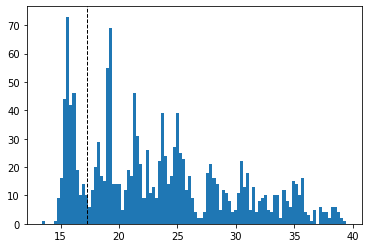

In [44]:
PE_MIN = 0
PE_MAX = 100

def peDistribution(id):
    pe = daily[daily['id']==id][['date','id','name','pe']]
    pe = pe[(pe['pe'] > PE_MIN) & (pe['pe'] < PE_MAX)]
    return pe['pe'].tolist()

id = 1723
pe = peDistribution(id)
y, x, _ = plt.hist(pe, 100)
df_id = out[out['id']==id]
name = df_id['name'].iloc[0]
now_pe = df_id['pe'].iloc[0]
most_pe = round(x[np.where(y == y.max())][0], 2)
eps = df_id['eps'].iloc[0]

print(f"[{len(pe)}]", name)
print('[PE] :', '目前:', now_pe, 'most:', most_pe)
print('[EPS]:','目前:', eps)
plt.axvline(now_pe, color='k', linestyle='dashed', linewidth=1)

plt.show()

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,

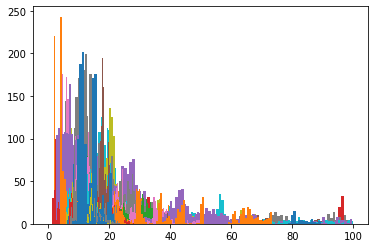

In [45]:
df_target = pd.DataFrame(columns=['count', 'id', 'name', 'now_pe','most_pe', 'avg_pe', 'eps', '收盤價', '偏離平均程度'])

def countTarget(id):
    pe = peDistribution(id)
    y, x, _ = plt.hist(pe, 100)
    df_id = out[out['id']==id]
    name = df_id['name'].iloc[0]
    now_pe = df_id['pe'].iloc[0]
    most_pe = round(x[np.where(y == y.max())][0], 2)
    avg_pe = df_id['avg_pe'].iloc[0]
    eps = df_id['eps'].iloc[0]
    close = df_id['收盤價'].iloc[0]
    cal_pe = min(most_pe, avg_pe)
    

    new_row = {'count': len(pe), 
               'id':id, 
               'name':name, 
               'now_pe':now_pe, 
               'most_pe':most_pe, 
               'avg_pe': avg_pe,
               'eps':eps, 
               '收盤價':close,
               '偏離平均程度':round(100*(cal_pe/now_pe - 1), 2)
              }
    
    df_target.loc[len(df_target)] = new_row
    

[countTarget(id) for id in filter1['id'].tolist()]

In [46]:
id = df_target['id'].isin(filter1['id'].tolist())

df_target_filter = (df_target[(df_target['count'] > 0)]) # 過濾pe數量>0
df_target_filter = df_target_filter.sort_values(by=['偏離平均程度'],ascending=False)
df_target_filter = df_target_filter.reset_index(drop=True)

df_target_filter

,count,id,name,now_pe,most_pe,avg_pe,eps,收盤價,偏離平均程度
0,495,1475,業旺,4.39,11.21,45.80,11.62,51.00,155.35
1,717,2482,連宇,9.97,20.72,20.66,3.96,39.50,107.22
2,1436,4536,拓凱,7.24,12.85,14.30,22.66,164.00,77.49
3,943,6715,嘉基,16.21,30.56,27.78,8.33,135.00,71.38
4,1436,6230,尼得科超眾,12.63,20.62,25.38,9.74,123.00,63.26
5,1436,4977,眾達-KY,9.72,15.79,20.04,8.09,78.60,62.45
6,1178,6670,復盛應用,7.29,11.55,11.46,28.11,205.00,57.20
7,1436,9802,鈺齊-KY,8.23,12.19,15.15,15.80,130.00,48.12
8,41,2065,世豐,8.90,12.73,12.33,6.47,57.60,38.54
9,1436,1722,台肥,14.01,19.24,23.35,4.31,60.40,37.33


In [47]:
# 偏離程度>20
bias = df_target_filter['偏離平均程度'] > 20
isLong = df_target_filter['id'].isin(long_ids)
isTorn = df_target_filter['id'].isin(torn_ids)
# df_target_filter[bias & isLong].to_csv(f'{today}_long.csv')
# df_target_filter[bias & isTorn].to_csv(f'{today}_torn.csv')
# df_target_filter[bias].to_csv(f'{today}_filter.csv')
df_bias = df_target_filter[bias]
print("、".join([f"{row['id']}{row['name']}" for index, row in df_bias.iterrows()]))

df_bias

1475業旺、2482連宇、4536拓凱、6715嘉基、6230尼得科超眾、4977眾達-KY、6670復盛應用、9802鈺齊-KY、2065世豐、1722台肥、2330台積電、3090日電貿、4557永新-KY、2484希華、8249菱光、8464億豐、3501維熹、3008大立光


,count,id,name,now_pe,most_pe,avg_pe,eps,收盤價,偏離平均程度
0,495,1475,業旺,4.39,11.21,45.80,11.62,51.00,155.35
1,717,2482,連宇,9.97,20.72,20.66,3.96,39.50,107.22
2,1436,4536,拓凱,7.24,12.85,14.30,22.66,164.00,77.49
3,943,6715,嘉基,16.21,30.56,27.78,8.33,135.00,71.38
4,1436,6230,尼得科超眾,12.63,20.62,25.38,9.74,123.00,63.26
5,1436,4977,眾達-KY,9.72,15.79,20.04,8.09,78.60,62.45
6,1178,6670,復盛應用,7.29,11.55,11.46,28.11,205.00,57.20
7,1436,9802,鈺齊-KY,8.23,12.19,15.15,15.80,130.00,48.12
8,41,2065,世豐,8.90,12.73,12.33,6.47,57.60,38.54
9,1436,1722,台肥,14.01,19.24,23.35,4.31,60.40,37.33


In [48]:
# bias_ids = df_target_filter[bias]['id'].tolist()
# df_prob[df_prob['id'].isin(bias_ids)].to_csv(f'{today}_probility.csv', index=False)

In [49]:
db.close()